In [22]:
from huggingface_hub import notebook_login


In [23]:
notebook_login()


In [1]:
from datasets import load_dataset


In [2]:
dataset = load_dataset("imagefolder", data_dir="../experimental/imgs/", split='train', drop_labels=False)


Resolving data files:   0%|          | 0/937 [00:00<?, ?it/s]

In [3]:
dataset


Dataset({
    features: ['image', 'label'],
    num_rows: 937
})

In [4]:
split_dataset = dataset.train_test_split(test_size=0.1)


In [5]:
from transformers import SwinForImageClassification, SwinConfig, TrainingArguments, Trainer


In [6]:
from datasets import load_metric

metric = load_metric("accuracy", trust_remote_code=True)


/var/folders/cn/l_vdrfmd0pxbx3p33nvb68wr0000gn/T/ipykernel_52305/884234914.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [7]:
example = split_dataset["train"][10]
example


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=105x100>,
 'label': 45}

In [8]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swinv2-base-patch4-window8-256")
feature_extractor


/Users/yusuke_fukasawa/Documents/github/poke_battle_logger/.venv/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

In [9]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size["width"], feature_extractor.size["height"])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size["width"], feature_extractor.size["height"])),
            CenterCrop((feature_extractor.size["width"], feature_extractor.size["height"])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


In [10]:
labels = split_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]


'アシレーヌ'

In [11]:
train_ds = split_dataset['train']
val_ds = split_dataset['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


In [12]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window8-256",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True)


Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([301, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([301]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model_name = "pokemon_image_classifier"
batch_size = 16

args = TrainingArguments(
    model_name,
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    no_cuda=True
)


/Users/yusuke_fukasawa/Documents/github/poke_battle_logger/.venv/lib/python3.12/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/yusuke_fukasawa/Documents/github/poke_battle_logger/.venv/lib/python3.12/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [14]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


In [15]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


In [16]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)


In [17]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


  0%|          | 0/260 [00:00<?, ?it/s]

{'loss': 5.7584, 'grad_norm': 4.771859169006348, 'learning_rate': 1.923076923076923e-05, 'epoch': 0.75}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 5.671351432800293, 'eval_accuracy': 0.02127659574468085, 'eval_runtime': 10.1425, 'eval_samples_per_second': 9.268, 'eval_steps_per_second': 0.592, 'epoch': 0.98}
{'loss': 5.6309, 'grad_norm': 3.609926700592041, 'learning_rate': 3.846153846153846e-05, 'epoch': 1.51}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 5.385910511016846, 'eval_accuracy': 0.02127659574468085, 'eval_runtime': 11.4649, 'eval_samples_per_second': 8.199, 'eval_steps_per_second': 0.523, 'epoch': 1.96}
{'loss': 5.3585, 'grad_norm': 4.7384867668151855, 'learning_rate': 4.9145299145299147e-05, 'epoch': 2.26}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 4.615903377532959, 'eval_accuracy': 0.2553191489361702, 'eval_runtime': 12.5344, 'eval_samples_per_second': 7.499, 'eval_steps_per_second': 0.479, 'epoch': 2.94}
{'loss': 4.8572, 'grad_norm': 9.58281135559082, 'learning_rate': 4.700854700854701e-05, 'epoch': 3.02}
{'loss': 4.1523, 'grad_norm': 10.519486427307129, 'learning_rate': 4.4871794871794874e-05, 'epoch': 3.77}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.5460474491119385, 'eval_accuracy': 0.4148936170212766, 'eval_runtime': 12.4722, 'eval_samples_per_second': 7.537, 'eval_steps_per_second': 0.481, 'epoch': 4.0}
{'loss': 3.3037, 'grad_norm': 11.443527221679688, 'learning_rate': 4.2735042735042735e-05, 'epoch': 4.53}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.7778232097625732, 'eval_accuracy': 0.574468085106383, 'eval_runtime': 12.2246, 'eval_samples_per_second': 7.689, 'eval_steps_per_second': 0.491, 'epoch': 4.98}
{'loss': 2.6911, 'grad_norm': 11.958502769470215, 'learning_rate': 4.05982905982906e-05, 'epoch': 5.28}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.1879918575286865, 'eval_accuracy': 0.6170212765957447, 'eval_runtime': 11.6293, 'eval_samples_per_second': 8.083, 'eval_steps_per_second': 0.516, 'epoch': 5.96}
{'loss': 2.282, 'grad_norm': 12.227787971496582, 'learning_rate': 3.846153846153846e-05, 'epoch': 6.04}
{'loss': 1.7291, 'grad_norm': 10.680749893188477, 'learning_rate': 3.6324786324786323e-05, 'epoch': 6.79}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.8558681011199951, 'eval_accuracy': 0.7127659574468085, 'eval_runtime': 11.0561, 'eval_samples_per_second': 8.502, 'eval_steps_per_second': 0.543, 'epoch': 6.94}
{'loss': 1.5736, 'grad_norm': 8.294869422912598, 'learning_rate': 3.418803418803419e-05, 'epoch': 7.55}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.609816551208496, 'eval_accuracy': 0.7872340425531915, 'eval_runtime': 12.0964, 'eval_samples_per_second': 7.771, 'eval_steps_per_second': 0.496, 'epoch': 8.0}
{'loss': 1.2275, 'grad_norm': 9.884180068969727, 'learning_rate': 3.205128205128206e-05, 'epoch': 8.3}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.404447078704834, 'eval_accuracy': 0.7978723404255319, 'eval_runtime': 10.5015, 'eval_samples_per_second': 8.951, 'eval_steps_per_second': 0.571, 'epoch': 8.98}
{'loss': 1.1316, 'grad_norm': 7.7315897941589355, 'learning_rate': 2.9914529914529915e-05, 'epoch': 9.06}
{'loss': 0.9186, 'grad_norm': 7.006025791168213, 'learning_rate': 2.777777777777778e-05, 'epoch': 9.81}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.2606635093688965, 'eval_accuracy': 0.8404255319148937, 'eval_runtime': 11.0361, 'eval_samples_per_second': 8.517, 'eval_steps_per_second': 0.544, 'epoch': 9.96}
{'loss': 0.7904, 'grad_norm': 6.339583873748779, 'learning_rate': 2.564102564102564e-05, 'epoch': 10.57}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1749556064605713, 'eval_accuracy': 0.8617021276595744, 'eval_runtime': 11.1867, 'eval_samples_per_second': 8.403, 'eval_steps_per_second': 0.536, 'epoch': 10.94}
{'loss': 0.7375, 'grad_norm': 6.375482082366943, 'learning_rate': 2.3504273504273504e-05, 'epoch': 11.32}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.066470980644226, 'eval_accuracy': 0.8723404255319149, 'eval_runtime': 10.1186, 'eval_samples_per_second': 9.29, 'eval_steps_per_second': 0.593, 'epoch': 12.0}
{'loss': 0.687, 'grad_norm': 6.639621257781982, 'learning_rate': 2.1367521367521368e-05, 'epoch': 12.08}
{'loss': 0.611, 'grad_norm': 6.168306350708008, 'learning_rate': 1.923076923076923e-05, 'epoch': 12.83}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0520755052566528, 'eval_accuracy': 0.8829787234042553, 'eval_runtime': 9.024, 'eval_samples_per_second': 10.417, 'eval_steps_per_second': 0.665, 'epoch': 12.98}
{'loss': 0.5002, 'grad_norm': 4.111606121063232, 'learning_rate': 1.7094017094017095e-05, 'epoch': 13.58}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0372234582901, 'eval_accuracy': 0.8829787234042553, 'eval_runtime': 9.2279, 'eval_samples_per_second': 10.187, 'eval_steps_per_second': 0.65, 'epoch': 13.96}
{'loss': 0.4759, 'grad_norm': 4.218101501464844, 'learning_rate': 1.4957264957264958e-05, 'epoch': 14.34}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.01197350025177, 'eval_accuracy': 0.8829787234042553, 'eval_runtime': 9.4495, 'eval_samples_per_second': 9.948, 'eval_steps_per_second': 0.635, 'epoch': 14.94}
{'loss': 0.5074, 'grad_norm': 6.960679531097412, 'learning_rate': 1.282051282051282e-05, 'epoch': 15.09}
{'loss': 0.4612, 'grad_norm': 7.316905498504639, 'learning_rate': 1.0683760683760684e-05, 'epoch': 15.85}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0013195276260376, 'eval_accuracy': 0.8829787234042553, 'eval_runtime': 10.3109, 'eval_samples_per_second': 9.117, 'eval_steps_per_second': 0.582, 'epoch': 16.0}
{'loss': 0.4635, 'grad_norm': 7.071527004241943, 'learning_rate': 8.547008547008548e-06, 'epoch': 16.6}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.9854071736335754, 'eval_accuracy': 0.8829787234042553, 'eval_runtime': 9.0656, 'eval_samples_per_second': 10.369, 'eval_steps_per_second': 0.662, 'epoch': 16.98}
{'loss': 0.4809, 'grad_norm': 6.130165100097656, 'learning_rate': 6.41025641025641e-06, 'epoch': 17.36}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.9770564436912537, 'eval_accuracy': 0.8829787234042553, 'eval_runtime': 9.386, 'eval_samples_per_second': 10.015, 'eval_steps_per_second': 0.639, 'epoch': 17.96}
{'loss': 0.4018, 'grad_norm': 7.1028151512146, 'learning_rate': 4.273504273504274e-06, 'epoch': 18.11}
{'loss': 0.3839, 'grad_norm': 5.274391174316406, 'learning_rate': 2.136752136752137e-06, 'epoch': 18.87}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.9762952923774719, 'eval_accuracy': 0.8829787234042553, 'eval_runtime': 9.6036, 'eval_samples_per_second': 9.788, 'eval_steps_per_second': 0.625, 'epoch': 18.94}
{'loss': 0.362, 'grad_norm': 5.324009418487549, 'learning_rate': 0.0, 'epoch': 19.62}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.9754350781440735, 'eval_accuracy': 0.8829787234042553, 'eval_runtime': 10.0077, 'eval_samples_per_second': 9.393, 'eval_steps_per_second': 0.6, 'epoch': 19.62}
{'train_runtime': 5350.4696, 'train_samples_per_second': 3.151, 'train_steps_per_second': 0.049, 'train_loss': 1.8260414692071767, 'epoch': 19.62}
***** train metrics *****
  epoch                    =      19.6226
  total_flos               = 1585066477GF
  train_loss               =        1.826
  train_runtime            =   1:29:10.46
  train_samples_per_second =        3.151
  train_steps_per_second   =        0.049


In [18]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


  0%|          | 0/6 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =    19.6226
  eval_accuracy           =      0.883
  eval_loss               =     1.0521
  eval_runtime            = 0:00:09.80
  eval_samples_per_second =      9.588
  eval_steps_per_second   =      0.612


In [19]:
# 推論テスト
import cv2
from PIL import Image
from transformers import pipeline

classifier_pipe = pipeline(task="image-classification", model=trainer.model, feature_extractor=feature_extractor)
pokemon_image = cv2.imread("../template_images/user_labeled_pokemon_templates/ヒスイヌメルゴン/20230719104544.png")
pokemon_image2 = cv2.cvtColor(pokemon_image, cv2.COLOR_BGR2RGB)
pokemon_image3 = Image.fromarray(pokemon_image2)
classifier_pipe(pokemon_image3)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'ヒスイヌメルゴン', 'score': 0.9919082522392273},
 {'label': 'ガラルマタドガス', 'score': 0.0003775506920646876},
 {'label': 'ヌメルゴン', 'score': 0.00027148297522217035},
 {'label': 'ドーブル', 'score': 0.0002558927226345986},
 {'label': 'コノヨザル', 'score': 0.00025039564934559166}]

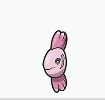

In [39]:
val_ds[0]['image']


In [40]:
classifier_pipe(val_ds[0]['image'])


[{'label': 'ママンボウ', 'score': 0.9804229736328125},
 {'label': 'モロバレル', 'score': 0.0012637354666367173},
 {'label': 'ヒスイヌメルゴン', 'score': 0.0011906875297427177},
 {'label': 'ラッキー', 'score': 0.001051618019118905},
 {'label': 'ハピナス', 'score': 0.000867854745592922}]

In [20]:
for idx, _val in enumerate(val_ds):
    predict = classifier_pipe(_val['image'])
    _label = id2label[_val["label"]]
    print(idx, predict[0], _label)


0 {'label': 'マスカーニャ', 'score': 0.9895569682121277} マスカーニャ
1 {'label': 'グライオン', 'score': 0.9900593757629395} グライオン
2 {'label': 'ミミズズ', 'score': 0.9920355677604675} ミミズズ
3 {'label': 'グライオン', 'score': 0.9934031367301941} グライオン
4 {'label': 'エルフーン', 'score': 0.08571778237819672} マホイップ
5 {'label': 'ルチャブル', 'score': 0.6323214173316956} ルチャブル
6 {'label': 'ドラパルト', 'score': 0.9901174902915955} ドラパルト
7 {'label': 'アローラキュウコン', 'score': 0.9743554592132568} アローラキュウコン
8 {'label': 'ファイヤー', 'score': 0.9720124006271362} ファイヤー
9 {'label': 'ヤバソチャ', 'score': 0.9827693700790405} ヤバソチャ
10 {'label': 'ミミッキュ', 'score': 0.9887194037437439} ミミッキュ
11 {'label': 'マスカーニャ', 'score': 0.9952548742294312} マスカーニャ
12 {'label': 'マスカーニャ', 'score': 0.9945986270904541} マスカーニャ
13 {'label': 'マスカーニャ', 'score': 0.9918808341026306} マスカーニャ
14 {'label': 'ドドゲザン', 'score': 0.9960119724273682} ドドゲザン
15 {'label': 'ラティオス', 'score': 0.9856430888175964} ラティオス
16 {'label': 'ガラルマタドガス', 'score': 0.3516274690628052} ガラルマタドガス
17 {'label': 'エースバーン

In [25]:
from huggingface_hub import upload_file

upload_file(
    path_or_fileobj="pokemon_image_classifier/config.json",
    path_in_repo="config.json",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)


CommitInfo(commit_url='https://huggingface.co/fufufukakaka/pokemon_image_classifier/commit/655601c1b799114e9af35155790ffd5903acc13b', commit_message='Upload config.json with huggingface_hub', commit_description='', oid='655601c1b799114e9af35155790ffd5903acc13b', pr_url='https://huggingface.co/fufufukakaka/pokemon_image_classifier/discussions/42', pr_revision='refs/pr/42', pr_num=42)

In [26]:
upload_file(
    path_or_fileobj="pokemon_image_classifier/model.safetensors",
    path_in_repo="model.safetensors",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)


model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/fufufukakaka/pokemon_image_classifier/commit/209082608c2c2b1431acc0c3f36999ecc1e24242', commit_message='Upload model.safetensors with huggingface_hub', commit_description='', oid='209082608c2c2b1431acc0c3f36999ecc1e24242', pr_url='https://huggingface.co/fufufukakaka/pokemon_image_classifier/discussions/43', pr_revision='refs/pr/43', pr_num=43)

In [27]:
upload_file(
    path_or_fileobj="pokemon_image_classifier/preprocessor_config.json",
    path_in_repo="preprocessor_config.json",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)


CommitInfo(commit_url='https://huggingface.co/fufufukakaka/pokemon_image_classifier/commit/b36a7585d9107b683b2e5819ede2c3cb200d3d13', commit_message='Upload preprocessor_config.json with huggingface_hub', commit_description='', oid='b36a7585d9107b683b2e5819ede2c3cb200d3d13', pr_url='https://huggingface.co/fufufukakaka/pokemon_image_classifier/discussions/44', pr_revision='refs/pr/44', pr_num=44)